## Import

In [148]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

%matplotlib inline

# Set seaborn style for professional plots
sns.set_style("darkgrid")  # Options: darkgrid, whitegrid, dark, white, ticks
sns.set_palette("husl")  # Set color palette

## DJIA_table.csv

In [149]:
data = pd.read_csv('../data/raw/DJIA_table.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date').reset_index(drop=True)

# CLEAN: forcer colonnes numériques (gère virgules, espaces, chaînes)
num_cols = ['Open','High','Low','Close','Adj Close','Volume']
for c in num_cols:
    if c in data.columns:
        data[c] = pd.to_numeric(data[c].astype(str).str.replace(r'[,\\s]', '', regex=True),
                                errors='coerce')

data.columns = data.columns.str.strip()
num_cols = ['Open','High','Low','Close','Adj Close','Volume']
for c in num_cols:
    if c in data.columns:
        data[c] = pd.to_numeric(data[c].astype(str).str.replace(r'[,\\s]', '', regex=True),
                                errors='coerce')

# garantir colonne ajustée utilisable (fallback sur Close)
adj_candidates = ['Adj Close', 'Adj_Close', 'AdjClose', 'Adjusted Close']
adj_col = next((c for c in adj_candidates if c in data.columns), None)
if adj_col is None:
    if 'Close' in data.columns:
        data['Adj Close'] = data['Close'].copy()
        adj_col = 'Adj Close'

In [150]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1989 entries, 0 to 1988
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1989 non-null   datetime64[ns]
 1   Open       1989 non-null   float64       
 2   High       1989 non-null   float64       
 3   Low        1989 non-null   float64       
 4   Close      1989 non-null   float64       
 5   Volume     1989 non-null   int64         
 6   Adj Close  1989 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 108.9 KB


In [151]:
data.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2008-08-08,11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312
1,2008-08-11,11729.669922,11867.110352,11675.530273,11782.349609,183190000,11782.349609
2,2008-08-12,11781.700195,11782.349609,11601.519531,11642.469727,173590000,11642.469727
3,2008-08-13,11632.809570,11633.780273,11453.339844,11532.959961,182550000,11532.959961
4,2008-08-14,11532.070312,11718.280273,11450.889648,11615.929688,159790000,11615.929688


### some plots

In [152]:
def plot_price(data, window=None, x_ticks=True, col="Adj Close", ax=None):
    # Create figure only if no axis is provided
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 6))
    
    # Make background transparent
    ax.patch.set_alpha(0.7)  # Fully transparent axes background

    if window:
        data = data.loc[(data['Date'] >= window[0]) & (data['Date'] <= window[1])]

    # Top plot: Closing Price
    ax.plot(data['Date'], data[col], label=f'{col}', 
            color='#2E86AB', linewidth=1.5, alpha=0.9)

    # Styling for price plot
    ax.set_ylabel(f'{col}', fontsize=14, fontweight='bold')
    ax.grid(True, linestyle='--')
    ax.legend(framealpha=0.9)

    # Format x-axis dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    
    # Remove x-axis ticks if specified
    if not x_ticks:
        ax.set(xticklabels=[])
    else:
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right') 
        
    return ax

Text(0.5, 1.0, 'DJIA Trading Time Series')

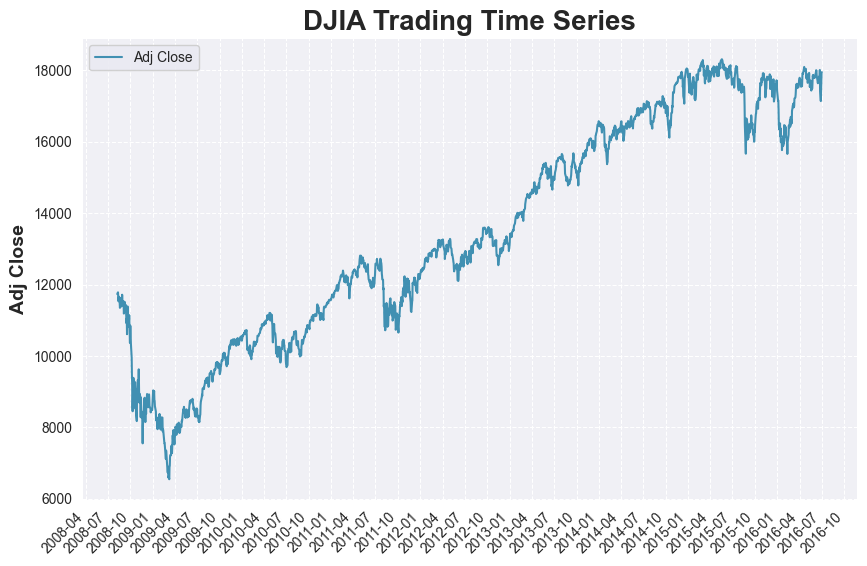

In [153]:
window = None
ax = plot_price(data, window)
plt.title("DJIA Trading Time Series", fontsize=20, fontweight='bold')




In [154]:
def plot_volume(data, window=None):
    _, ax = plt.subplots(figsize=(10, 6))
    red, green = '#DC3545', '#28A745'
    if window:
        data = data.loc[(data['Date'] >= window[0]) & (data['Date'] <= window[1])]
    
    colors = [green if data.loc[i, 'Adj Close'] >= data.loc[i, 'Open'] 
            else red for i in range(len(data))]
    ax.bar(data['Date'], data['Volume'], color=colors, alpha=0.6, width=1)
    ax.set_ylabel('Volume', fontsize=12, fontweight='bold')
    ax.set_xlabel('Date', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle='--', axis='y')

    # Format x-axis dates for volume plot
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')


# plt.tight_layout()
# plt.show()


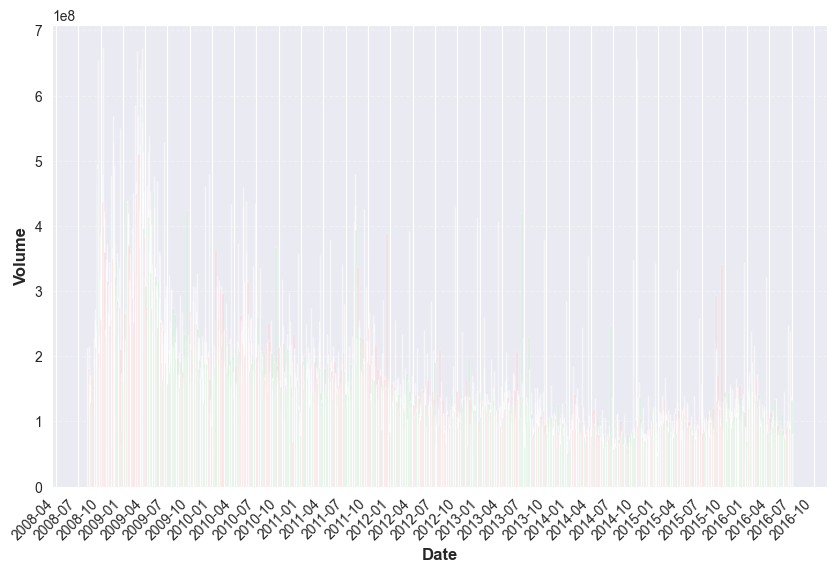

In [155]:
plot_volume(data)

### Dollar volume

In [156]:
data['Dollar Volume'] = data['Volume'] * data['Adj Close']/1e6
data['Dollar Volume'] 

0       2.497415e+06
1       2.158409e+06
2       2.021016e+06
3       2.105342e+06
4       1.856109e+06
            ...     
1984    2.378037e+06
1985    1.953197e+06
1986    1.882360e+06
1987    2.385227e+06
1988    1.474720e+06
Name: Dollar Volume, Length: 1989, dtype: float64

## Volatily Indicators

### Average True Range (ATR)

In [157]:
days = 14
atr = ta.atr(high=data['High'], 
            low=data['Low'], 
            close=data['Close'], 
            length=days)
data['ATR'] = atr.sub(atr.mean()).div(atr.std())


C:\Users\User\AppData\Local\Temp\ipykernel_23044\2543744271.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


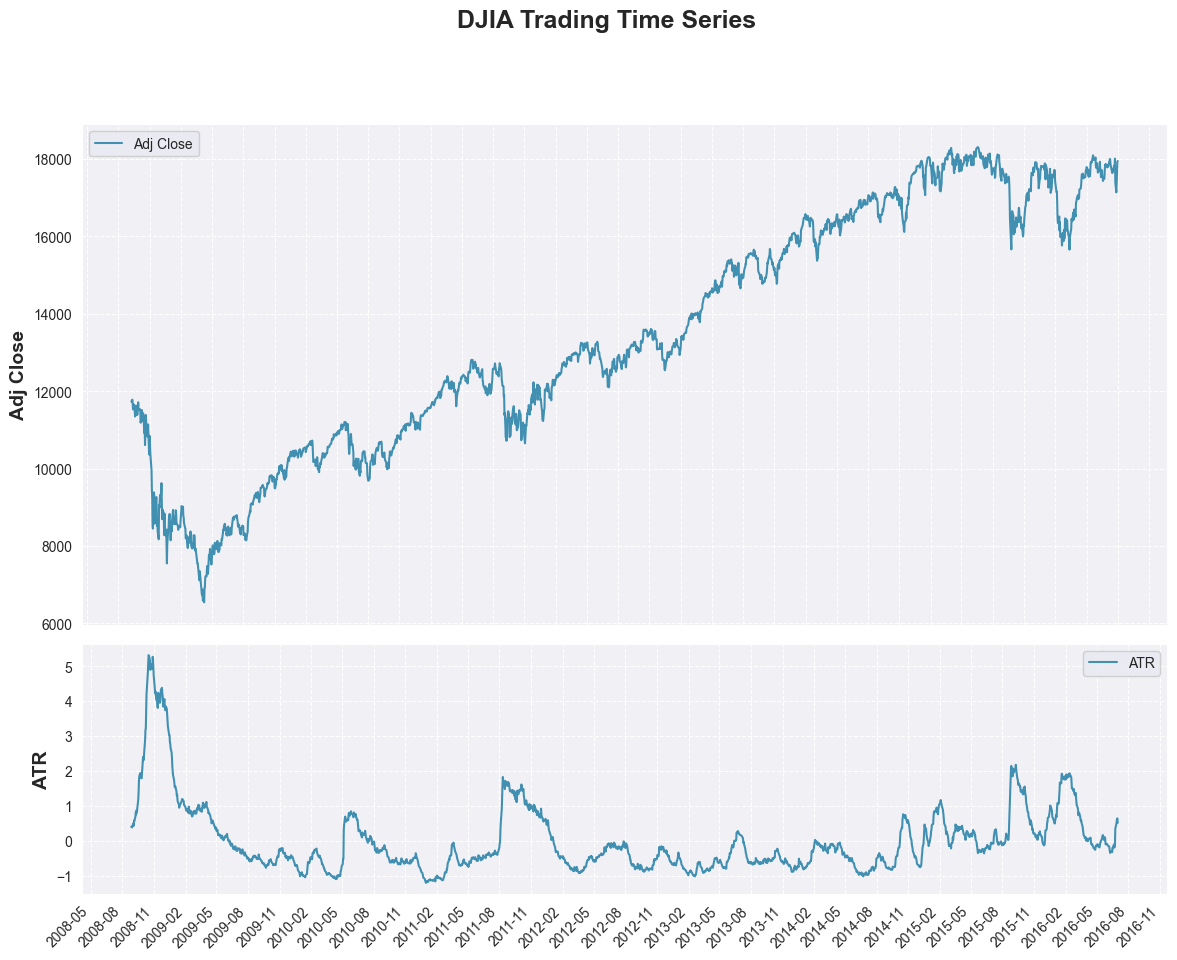

In [158]:
window = None

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), 
                                gridspec_kw={'height_ratios': [2, 1], 'hspace': 0.05})

# Add title to the figure
fig.suptitle('DJIA Trading Time Series', fontsize=18, fontweight='bold', y=0.995)

# Plot Close price on top subplot
plot_price(data, window, x_ticks=False, col="Adj Close", ax=ax1)

# Plot ATR on bottom subplot
plot_price(data, window, x_ticks=True, col='ATR', ax=ax2)

plt.tight_layout()
plt.show()



### Bollinger Bands

- A volatility-based envelope around price
- They show volatility expansions and contractions and potential overbought/oversold conditions.

Maybe use log(Adj Close) before applying bbands (to have volatility in percentages.). The bands remain proportional to the asset's growth rate rather than its raw price level. (variance stabilization)

$ln(1+r) \approx r$ and $r = \frac{P_t - P_{t-1}}{P_t}$

**Conclusion:** The difference between log prices is approximately equal to the simple percentage return.

In [159]:
# from pandas_ta
bb_low_tab = ta.bbands(np.log1p(data['Adj Close']) , length=20, std=2)


In [160]:
days = 20
log_adj_close = np.log1p(data['Adj Close'])
sma = log_adj_close.rolling(window=days).mean()
k = 2
bb_low = sma - k * log_adj_close.rolling(window=days).std()
bb_high = sma + k * log_adj_close.rolling(window=days).std()
bb_mid = (bb_low + bb_high) / 2

data["bb_low"] = bb_low
data["bb_high"] = bb_high
data["bb_mid"] = bb_mid


### Garman-Klass Volatily (GKV) don't use

In [161]:
op_left = ((np.log(data['High']) - np.log(data['Low']))**2)/2 
op_right = (2*np.log(2)-1)*(np.log(data['Close']) - np.log(data['Open']))**2
data['GKV'] = op_left - op_right

### Moving Average Convergence Divergence (MACD)

It shows trend direction, strength, and momentum shifts.

- MACD line $= EMA_{12} - EMA_{26}$
- Signal line $= EMA_{9}(MACD line)$

In [162]:
days = 12
macd = ta.macd(data['Adj Close'], length=days).iloc[:, 0]
macd 
data["MACD"] = macd.sub(macd.mean()).div(macd.std())

## Momemtum indicators

### Relative Strenght Index (RSI)



A momentum oscillator from 0–100 measuring speed and magnitude of price changes.

Up periods:

- $U = close_{now} - close_{previous}$
- $D = 0$

Down periods:

- $U = 0$
- $D = close_{previous} - close_{now}$

$RSI = 100 - \frac{100}{1+RS}$, $RS=\frac{SMMA(U, n)}{SMMA(D, n)}$

In [163]:
#with pandas_ta
days = 14
data["RSI"] = ta.rsi(data['Adj Close'], length=days)


#with pandas

In [164]:
days = 14
smma = ta.smma(data['Adj Close'], length=days)

### Month return don't use

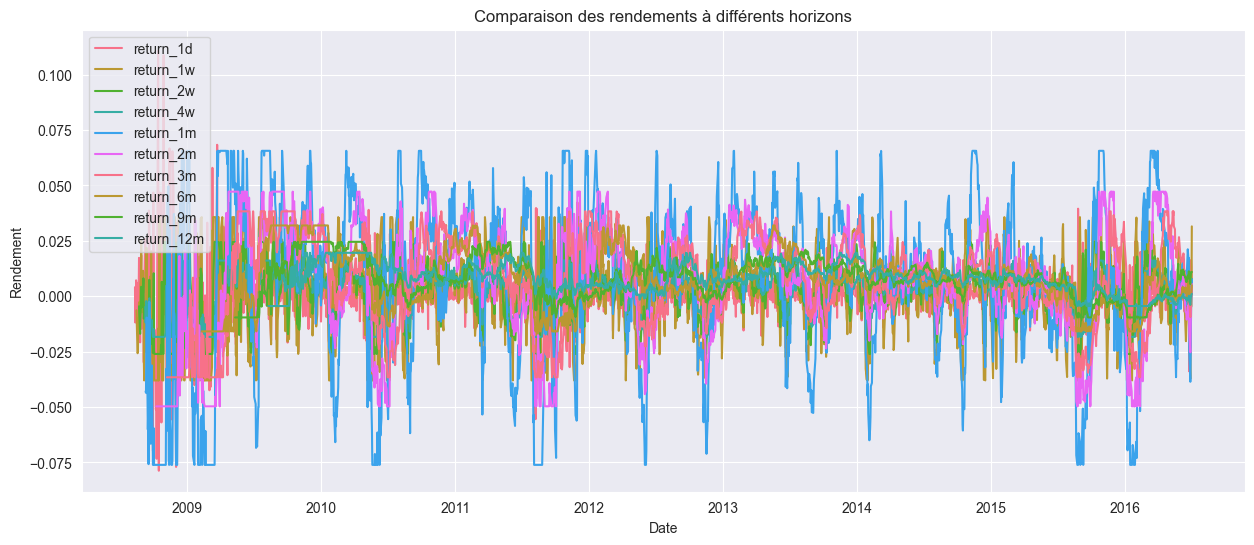

In [165]:
outlier_cutoff = 0.05
monthly_lags = [1, 2, 3, 6, 9, 12]  # months 21 trading days
weekly_lags  = [1, 2, 4]            # weeks 5 trading days

# rendement 1d (simple + log) sur colonne ajustée
data['return_1d'] = data[adj_col].pct_change()
data['log_return_1d'] = np.log(data[adj_col]).diff()

def _clean_and_mean_per_period(raw_series, periods, outlier_cutoff=0.05):
    # clippe extrêmes via quantiles puis convertit un rendement cumulé R over N periods
    # en rendement moyen par période (géométrique) : (1+R)^(1/N)-1
    clean = raw_series.clip(lower=raw_series.quantile(outlier_cutoff),
                             upper=raw_series.quantile(1 - outlier_cutoff))
    with np.errstate(divide='ignore', invalid='ignore'):
        per_period = (clean.add(1)).pow(1.0 / periods).sub(1)
    return per_period

# weekly returns (convertir change sur 5*lag jours -> rendement moyen par semaine)
for lag in weekly_lags:
    days = 5 * lag
    raw = data[adj_col].pct_change(periods=days)
    data[f'return_{lag}w'] = _clean_and_mean_per_period(raw, periods=lag, outlier_cutoff=outlier_cutoff)

# monthly returns (change sur ~21*lag jours -> rendement moyen par mois)
for lag in monthly_lags:
    days = int(round(21 * lag))
    raw = data[adj_col].pct_change(periods=days)
    data[f'return_{lag}m'] = _clean_and_mean_per_period(raw, periods=lag, outlier_cutoff=outlier_cutoff)

data.head()

data = data.set_index('Date')
cols = ['return_1d'] + \
       [f'return_{lag}w' for lag in weekly_lags] + \
       [f'return_{lag}m' for lag in monthly_lags]

plt.figure(figsize=(15,6))
for c in cols:
    plt.plot(data.index, data[c], label=c)

plt.title("Comparaison des rendements à différents horizons")
plt.xlabel("Date")
plt.ylabel("Rendement")
plt.legend()
plt.show()



### Fama-french indicators

In [166]:
import pandas as pd
import requests
import zipfile
import io

# URL for the Fama-French 5-factor daily data zip file
ff_url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_DAILY_CSV.zip"

print("Downloading Fama-French 5 factors data...")
# Download the file content
try:
    response = requests.get(ff_url)
    response.raise_for_status()  # Raise an exception for bad status codes
    zip_file = zipfile.ZipFile(io.BytesIO(response.content))
    
    # The actual data file is the first file in the zip archive
    csv_file_name = zip_file.namelist()[0]

    # Read the data, skipping the header metadata. The actual data starts at line 4.
    # The file has a weird format, so we read it as a basic CSV first.
    ff_df = pd.read_csv(zip_file.open(csv_file_name), skiprows=3)

    # The file contains footer text at the end which we need to remove.
    # Let's find where the column 'Unnamed: 0' (the date column) becomes non-numeric.
    first_footer_line = pd.to_numeric(ff_df.iloc[:, 0], errors='coerce').isna().idxmax()
    ff_df = ff_df.iloc[:first_footer_line]

    # Set column names. The first column is the date.
    ff_df.columns = ['Date', 'Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']
    
    # Clean up and format the DataFrame
    ff_df['Date'] = pd.to_datetime(ff_df['Date'], format='%Y%m%d')
    ff_df.set_index('Date', inplace=True)

    # Convert factor columns to numeric and divide by 100 to get decimal returns
    factor_cols = ['Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']
    for col in factor_cols:
        ff_df[col] = pd.to_numeric(ff_df[col], errors='coerce') / 100

    # The 'data' DataFrame index was set to 'Date' in a previous cell.
    # We can now merge the Fama-French factors.
    data = data.merge(ff_df, left_index=True, right_index=True, how='left')

    print("Fama-French factors merged successfully.")
    # Display the last few rows to verify the merge
    print(data[['Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']].tail())

except requests.exceptions.RequestException as e:
    print(f"Error downloading the file: {e}")
except Exception as e:
    print(f"An error occurred during data processing: {e}")


Fama-French factors merged successfully.
            Mkt_RF     SMB     HML     RMW     CMA   RF
Date                                                   
2016-06-27 -0.0206 -0.0106 -0.0072  0.0062  0.0043  0.0
2016-06-28  0.0176 -0.0037  0.0016 -0.0063 -0.0057  0.0
2016-06-29  0.0179  0.0031 -0.0004 -0.0013 -0.0026  0.0
2016-06-30  0.0142  0.0039  0.0042 -0.0011  0.0038  0.0
2016-07-01  0.0024  0.0046 -0.0043 -0.0007  0.0023  0.0


Plotting cumulative factor performance...


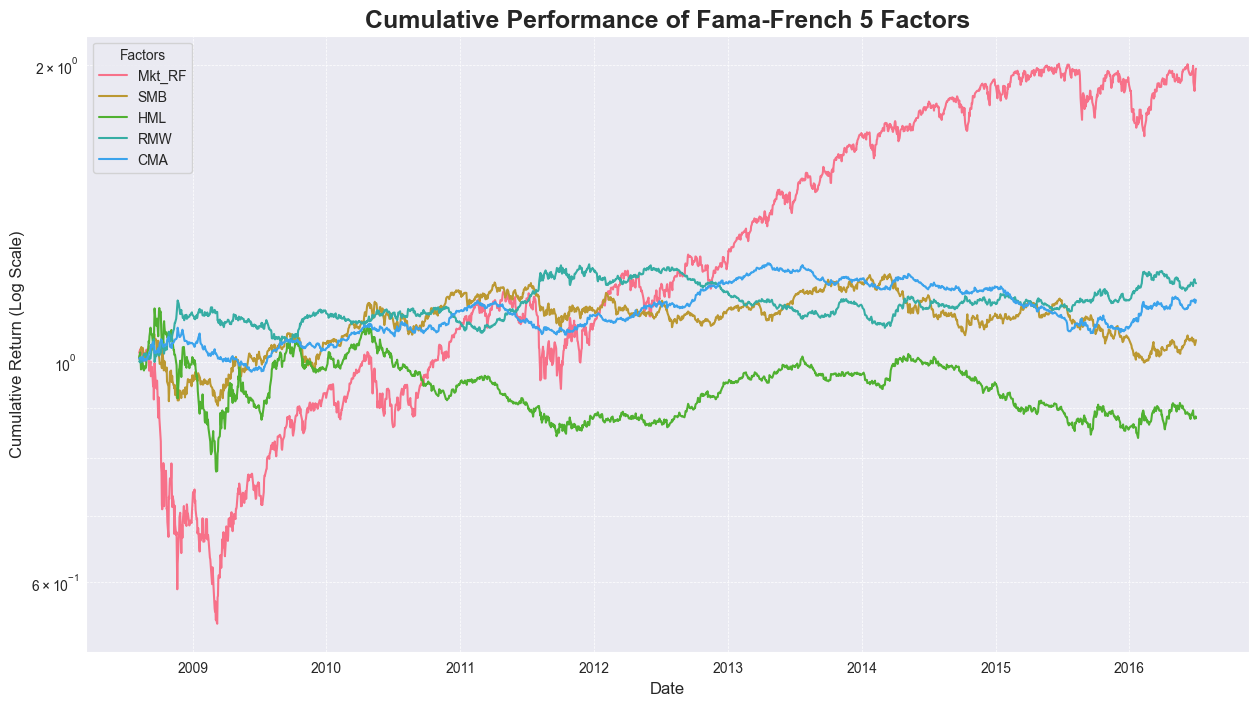

In [167]:

# Plotting the cumulative performance of the Fama-French factors
factor_cols = ['Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA']

# Check if the columns exist in the dataframe before plotting
if all(col in data.columns for col in factor_cols):
    print("Plotting cumulative factor performance...")
    plt.figure(figsize=(15, 8))
    
    # Calculate and plot the cumulative product of (1 + factor return)
    # We will use a slice of the data where the factors are not NaN
    plot_data = data[data['Mkt_RF'].notna()].copy()
    
    for factor in factor_cols:
        cumulative_return = (1 + plot_data[factor]).cumprod()
        plt.plot(cumulative_return.index, cumulative_return, label=factor)
        
    plt.title('Cumulative Performance of Fama-French 5 Factors', fontsize=18, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Cumulative Return (Log Scale)', fontsize=12)
    plt.yscale('log') # Log scale is better for comparing long-term growth
    plt.legend(title='Factors')
    plt.grid(True, which="both", ls="--", linewidth=0.5)
    plt.show()
else:
    print("Could not find Fama-French factor columns in the DataFrame.")
    print("Please ensure the previous cell for downloading and merging the data executed correctly.")


## VIX Volatility Index

In [168]:

import yfinance as yf

# Ensure the index is a datetime object before proceeding
if not pd.api.types.is_datetime64_any_dtype(data.index):
    data.index = pd.to_datetime(data.index)

# Get the start and end dates from our existing data
start_date = data.index.min().strftime('%Y-%m-%d')
end_date = data.index.max().strftime('%Y-%m-%d')

# Download VIX data
print(f"Downloading VIX data from {start_date} to {end_date}...")
try:
    vix_data_raw = yf.download('^VIX', start=start_date, end=end_date, progress=True, auto_adjust=True)

    vix_data = pd.DataFrame(vix_data_raw['Close'])
    vix_data = vix_data.rename(columns={'Close': 'VIX_Close'})

    # Merge it into our main dataframe
    data = data.merge(vix_data, left_index=True, right_index=True, how='left')

    print("VIX data merged successfully.")
    print("Displaying tail of the dataframe with VIX_Close:")
    print(data[['Adj Close', 'VIX_Close']].tail())

except Exception as e:
    print(f"Could not download or process VIX data. Error: {e}")


[*********************100%***********************]  1 of 1 completed

VIX data merged successfully.
Displaying tail of the dataframe with VIX_Close:
Could not download or process VIX data. Error: "['VIX_Close'] not in index"


In [169]:
# Plot DJIA Adj Close and VIX on a dual-axis plot
if 'VIX_Close' in data.columns and not data['VIX_Close'].isnull().all():
    fig, ax1 = plt.subplots(figsize=(15, 8))

    # Plot DJIA
    ax1.set_title('DJIA vs. VIX Index', fontsize=18, fontweight='bold')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('DJIA Adj Close', color='blue', fontsize=12)
    ax1.plot(data.index, data['Adj Close'], color='blue', label='DJIA Adj Close')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.grid(True, linestyle='--')

    # Create a second y-axis for the VIX
    ax2 = ax1.twinx()
    ax2.set_ylabel('VIX Close', color='red', fontsize=12)
    ax2.plot(data.index, data['VIX_Close'], color='red', label='VIX Close', alpha=0.7)
    ax2.tick_params(axis='y', labelcolor='red')

    # Due to twinx, we need to manually create the legend
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left')
    
    plt.show()
else:
    print("VIX_Close column not found or is empty. Skipping plot.")

VIX_Close column not found or is empty. Skipping plot.


## Stochastic Oscillator (%K, %D)

C:\Users\User\AppData\Local\Temp\ipykernel_23044\4047966492.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.98])


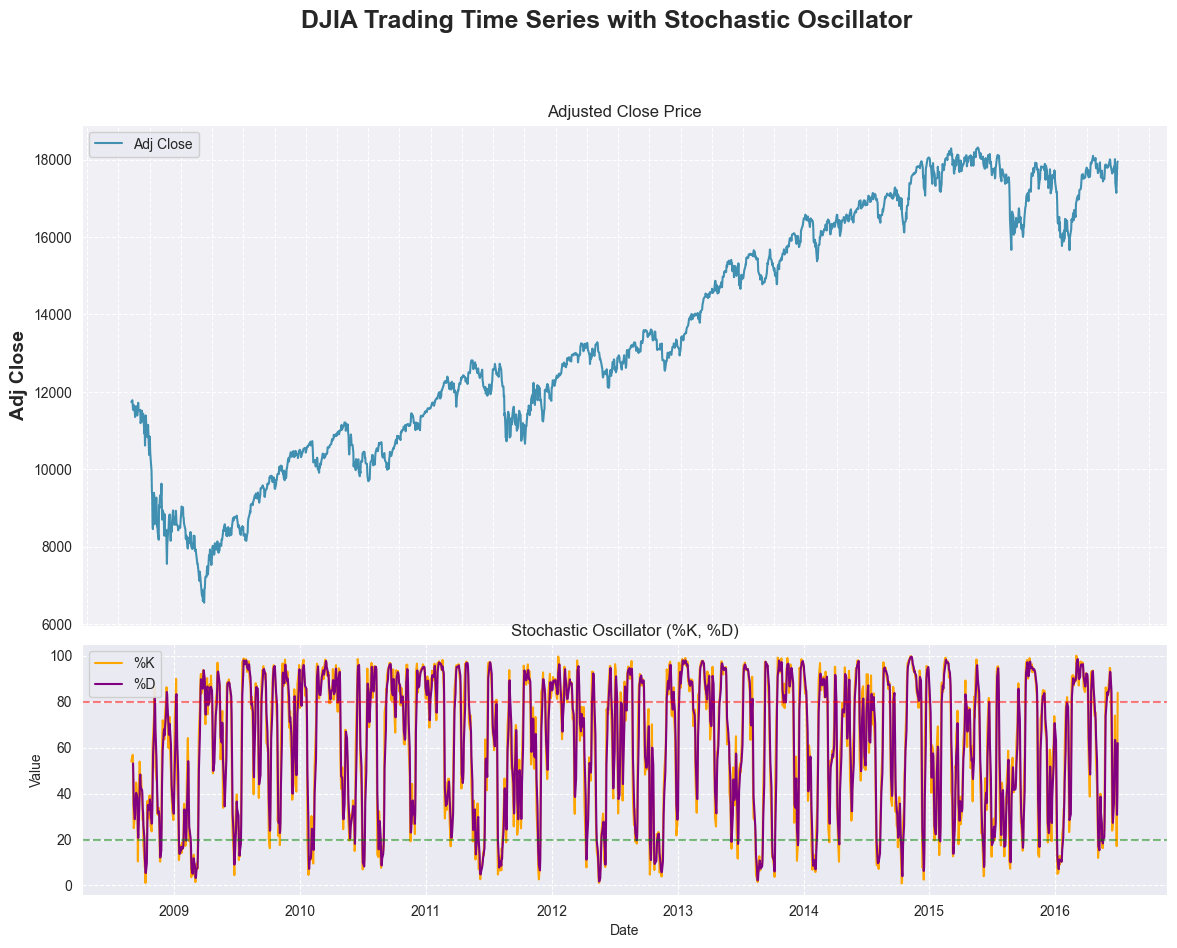

In [170]:
import pandas_ta as ta
import matplotlib.pyplot as plt

# Assurez-vous que 'data' est votre DataFrame avec les colonnes 'High', 'Low', 'Close'
# et que l'index est la date.

# Calculer l'oscillateur stochastique
stoch = ta.stoch(high=data['High'], low=data['Low'], close=data['Close'], k=14, d=3, smooth_k=3)
data['STOCHk'] = stoch.iloc[:,0]
data['STOCHd'] = stoch.iloc[:,1]

# Créer le graphique
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), 
                                gridspec_kw={'height_ratios': [2, 1], 'hspace': 0.05})

# Titre principal
fig.suptitle('DJIA Trading Time Series with Stochastic Oscillator', fontsize=18, fontweight='bold', y=0.995)

# Grraphique du prix de clôture ajusté
# La fonction plot_price est définie plus haut dans votre notebook
data_plot = data.reset_index()
plot_price(data_plot, window=None, x_ticks=False, col="Adj Close", ax=ax1)
ax1.set_title("Adjusted Close Price")

# Grraphique de l'oscillateur stochastique
ax2.plot(data.index, data['STOCHk'], label='%K', color='orange', linewidth=1.5)
ax2.plot(data.index, data['STOCHd'], label='%D', color='purple', linewidth=1.5)
ax2.set_title('Stochastic Oscillator (%K, %D)')
ax2.set_ylabel('Value')
ax2.axhline(80, linestyle='--', color='red', alpha=0.5)
ax2.axhline(20, linestyle='--', color='green', alpha=0.5)
ax2.set_xlabel('Date')
ax2.legend(framealpha=0.9)
ax2.grid(True, linestyle='--')

# Afficher le graphique
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()



## Feature Engineering

In [171]:
# 1. Définir les indicateurs et les fenêtres pour les moyennes mobiles
indicators_to_roll = ['ATR', 'MACD', 'RSI', 'STOCHk', 'STOCHd'] # Indicateurs créés précédemment
roll_windows = [5, 10, 21]

# 2. Créer des features décalées (lags)
# On utilise le rendement et le RSI du jour précédent comme features
data['return_1d_lag_1'] = data['return_1d'].shift(1)
data['RSI_lag_1'] = data['RSI'].shift(1)

# 3. Créer des features de moyennes mobiles
for indicator in indicators_to_roll:
    if indicator in data.columns:
        for window in roll_windows:
            data[f'{indicator}_roll_mean_{window}'] = data[indicator].rolling(window=window).mean()
    else:
        print(f"Attention : L'indicateur '{indicator}' est introuvable. Le calcul de la moyenne mobile est ignoré.")

# 4. Créer la variable cible (target)
# On cherche à prédire la direction du rendement du jour suivant (positif=1, négatif=-1, stable=0)
data['target'] = np.sign(data['return_1d'].shift(-1))

# 5. Nettoyer le jeu de données
print(f"Dimensions avant suppression des NaN : {data.shape}")

# Les opérations précédentes (lags, rolling, target shift) créent des valeurs manquantes (NaN).
# On supprime toutes les lignes qui contiennent au moins une valeur NaN.
data_featured = data.dropna()

print(f"Dimensions après suppression des NaN : {data_featured.shape}")
print("\nAperçu du DataFrame final avec les nouvelles features :")
print(data_featured.head())

# 6. Afficher un résumé des nouvelles features créées
print("\nRésumé de quelques features d'ingénierie :")
# Vérifions que les colonnes existent avant de les utiliser
desc_cols = ['return_1d_lag_1', 'RSI_lag_1', 'RSI_roll_mean_5', 'target']
existing_desc_cols = [col for col in desc_cols if col in data_featured.columns]
if existing_desc_cols:
    print(data_featured[existing_desc_cols].describe())
else:
    print("Aucune des colonnes de résumé spécifiées n'existe dans le DataFrame final.")

Dimensions avant suppression des NaN : (1989, 52)
Dimensions après suppression des NaN : (1736, 52)

Aperçu du DataFrame final avec les nouvelles features :
                   Open         High          Low        Close     Volume  \
Date                                                                        
2009-08-10  9368.410156  9371.959961  9290.339844  9337.950195  161370000   
2009-08-11  9334.330078  9334.330078  9216.879883  9241.450195  171380000   
2009-08-12  9236.059570  9424.110352  9221.019531  9361.610352  197420000   
2009-08-13  9362.290039  9406.500000  9305.309570  9398.190430  145620000   
2009-08-14  9398.040039  9401.969727  9232.830078  9321.400391  172780000   

              Adj Close  Dollar Volume       ATR    bb_low   bb_high  ...  \
Date                                                                  ...   
2009-08-10  9337.950195   1.506865e+06 -0.584447  9.047610  9.169388  ...   
2009-08-11  9241.450195   1.583800e+06 -0.588929  9.063935  9.163092  ..

## Modélisation

Forme des features (X) : (1736, 42)
Forme de la cible (y) : (1736,)
Nombre d'échantillons d'entraînement : 1388
Nombre d'échantillons de test : 348

Entraînement du modèle...
Entraînement terminé.

Accuracy sur l'ensemble de test : 47.70%
Rapport de classification :
              precision    recall  f1-score   support

        -1.0       0.40      0.12      0.19       171
         0.0       0.00      0.00      0.00         1
         1.0       0.49      0.82      0.61       176

    accuracy                           0.48       348
   macro avg       0.30      0.32      0.27       348
weighted avg       0.45      0.48      0.40       348

Matrice de confusion :


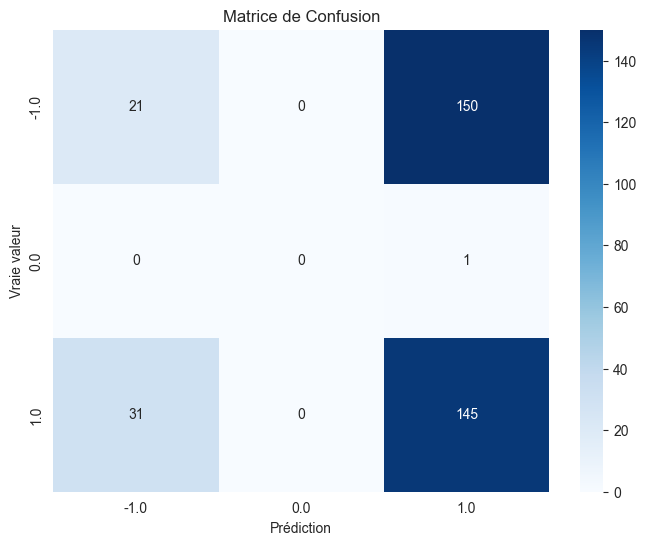

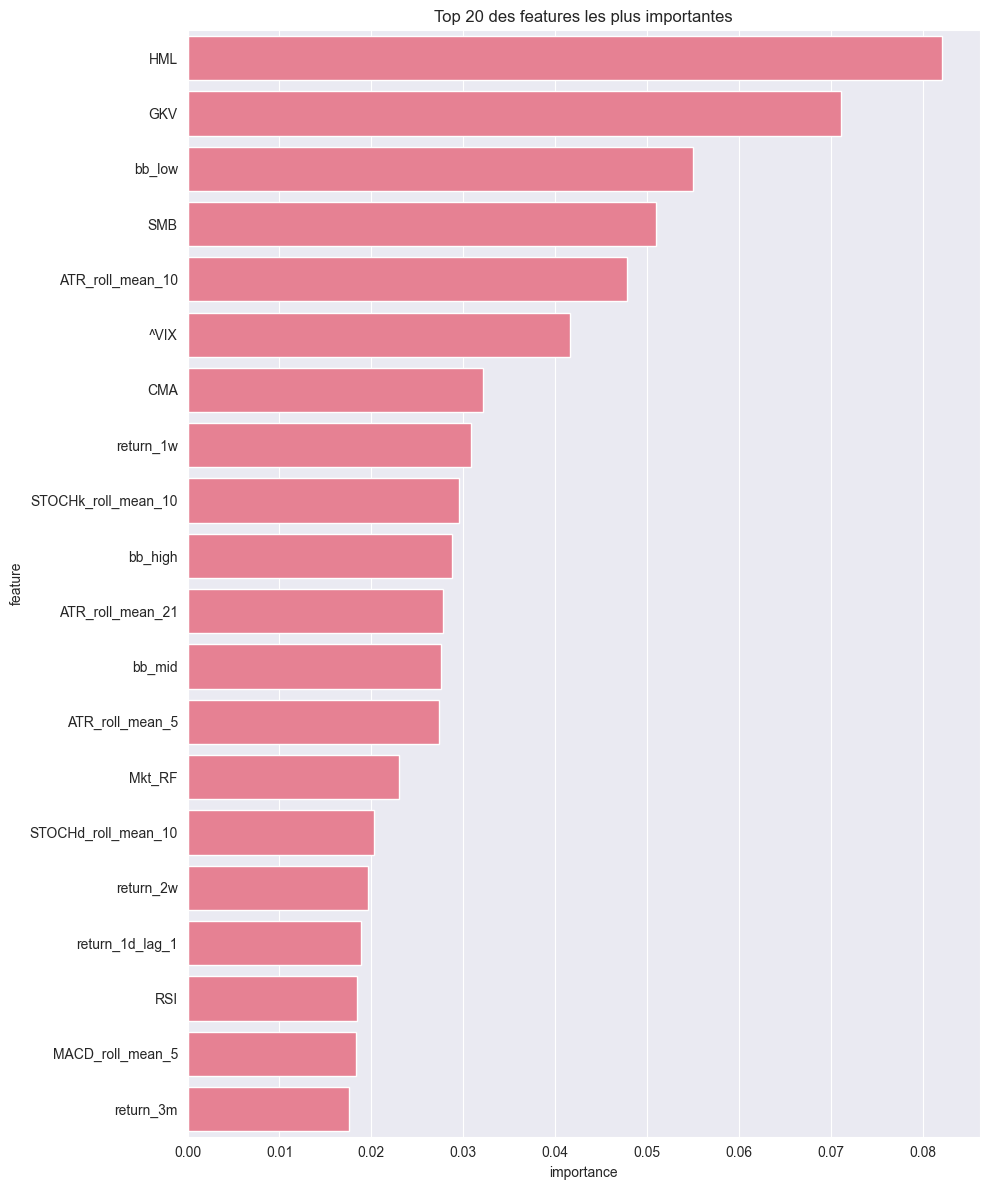

In [172]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Préparation des données pour le modèle ---
y = data_featured['target']
X = data_featured.drop(columns=[
    'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Dollar Volume',
    'return_1d', 'log_return_1d', 'target'
], errors='ignore')

# S'assurer qu'il n'y a pas de colonnes avec NaN/inf restantes dans X
# (Normalement déjà fait par le data_featured.dropna() précédent, mais c'est une sécurité)
X.replace([np.inf, -np.inf], np.nan, inplace=True)
if X.isnull().sum().sum() > 0:
    X.dropna(inplace=True)
    y = y[X.index] # Aligner y avec X après le dropna

print(f"Forme des features (X) : {X.shape}")
print(f"Forme de la cible (y) : {y.shape}")

# --- 2. Division des données (Train / Test) ---
# Pour les séries temporelles, la division doit être chronologique
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"Nombre d'échantillons d'entraînement : {len(X_train)}")
print(f"Nombre d'échantillons de test : {len(X_test)}")

# --- 3. Entraînement du modèle RandomForest ---
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')

print("\nEntraînement du modèle...")
model.fit(X_train, y_train)
print("Entraînement terminé.")

# --- 4. Évaluation du modèle ---
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy sur l'ensemble de test : {accuracy:.2%}")

print("Rapport de classification :")
print(classification_report(y_test, y_pred, zero_division=0))

print("Matrice de confusion :")
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Matrice de Confusion')
plt.xlabel('Prédiction')
plt.ylabel('Vraie valeur')
plt.show()

# --- 5. Analyse de l'importance des features ---
importances = model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20))
plt.title('Top 20 des features les plus importantes')
plt.tight_layout()
plt.show()

In [173]:
# --- Feature Engineering - Étape 2 ---
# Basé sur l'analyse de l'importance des features, nous allons créer de nouvelles features
# pour renforcer les signaux que le modèle semble apprécier.

print("Création de nouvelles features basée sur l'importance des features précédentes...")

# Copier le dataframe pour ne pas modifier l'original à chaque exécution
data_v2 = data_featured.copy()

# 1. Renforcer les signaux des facteurs Fama-French (les plus importants)
# On ajoute des moyennes mobiles pour voir leur tendance
if 'HML' in data_v2.columns and 'SMB' in data_v2.columns:
    data_v2['HML_roll_mean_21'] = data_v2['HML'].rolling(window=21).mean()
    data_v2['SMB_roll_mean_21'] = data_v2['SMB'].rolling(window=21).mean()
    print("- Features ajoutées : Moyennes mobiles sur 21 jours pour HML et SMB.")

# 2. Créer une feature de "volatilité réalisée"
# Le modèle aime GKV et VIX. Donnons-lui une autre mesure de volatilité.
data_v2['realized_vol_21'] = data_v2['log_return_1d'].rolling(window=21).std() * np.sqrt(252) # Volatilité annualisée
print("- Feature ajoutée : Volatilité réalisée sur 21 jours.")


# 3. Créer une feature d'interaction
# Le momentum est-il plus fort quand le VIX est bas ?
if 'VIX_Close' in data_v2.columns:
    # On normalise le VIX pour le garder à une échelle comparable
    vix_normalized = (data_v2['VIX_Close'] - data_v2['VIX_Close'].mean()) / data_v2['VIX_Close'].std()
    data_v2['return_1w_x_vix'] = data_v2['return_1w'] * vix_normalized
    print("- Feature ajoutée : Interaction entre le rendement sur 1 semaine et le VIX.")


# 4. Nettoyage et préparation finale
# Les nouvelles opérations de rolling créent des NaNs au début.
data_2class = data_v2.dropna()

print(f"\nDimensions du jeu de données après ajout des nouvelles features : {data_2class.shape}")

Création de nouvelles features basée sur l'importance des features précédentes...
- Features ajoutées : Moyennes mobiles sur 21 jours pour HML et SMB.
- Feature ajoutée : Volatilité réalisée sur 21 jours.

Dimensions du jeu de données après ajout des nouvelles features : (1716, 55)


# explication


Accuracy (47.70%) : C'est le score le plus simple, mais aussi le plus trompeur. Votre accuracy est inférieure à 50%. Cela signifie que vous auriez de meilleurs résultats en pariant simplement sur "hausse" à chaque fois (puisque la classe "1.0" est légèrement majoritaire). Le modèle n'est donc pas meilleur qu'un simple pile ou face.

Rapport de Classification (le plus important ici) :

Classe 1.0 (Hausse) :
recall: 0.82 : Le modèle identifie correctement 82% des jours de hausse réels. Il est donc bon pour détecter les hausses.
precision: 0.49 : MAIS, quand le modèle prédit une hausse, il n'a raison que 49% du temps. C'est le point crucial : il prédit "hausse" très (trop) souvent.
Classe -1.0 (Baisse) :
recall: 0.12 : C'est le plus gros problème. Le modèle ne détecte que 12% des jours de baisse. Il rate donc 88% des baisses, ce qui serait catastrophique pour une stratégie de trading.
precision: 0.40 : Quand il se risque à prédire "baisse", il a raison 40% du temps. C'est peu, mais cela montre qu'il n'est pas totalement aléatoire.
Classe 0.0 (Stable) : Le modèle ignore complètement cette classe car elle est trop rare (1 seul échantillon). C'est normal.
Conclusion de l'interprétation : Le modèle a appris une stratégie très basique et biaisée : "Dans le doute, prédis que le marché va monter". Cela lui permet de bien "rappeler" les hausses, mais au prix d'une précision médiocre et en manquant la quasi-totalité des baisses.

Forme des features (X) après filtrage : (1734, 42)
Forme de la cible (y) après filtrage : (1734,)

Nombre d'échantillons d'entraînement : 1387
Nombre d'échantillons de test : 347

Entraînement du modèle...
Entraînement terminé.

Accuracy sur l'ensemble de test : 51.01%
Rapport de classification :
              precision    recall  f1-score   support

        -1.0       0.51      0.25      0.33       171
         1.0       0.51      0.77      0.61       176

    accuracy                           0.51       347
   macro avg       0.51      0.51      0.47       347
weighted avg       0.51      0.51      0.47       347



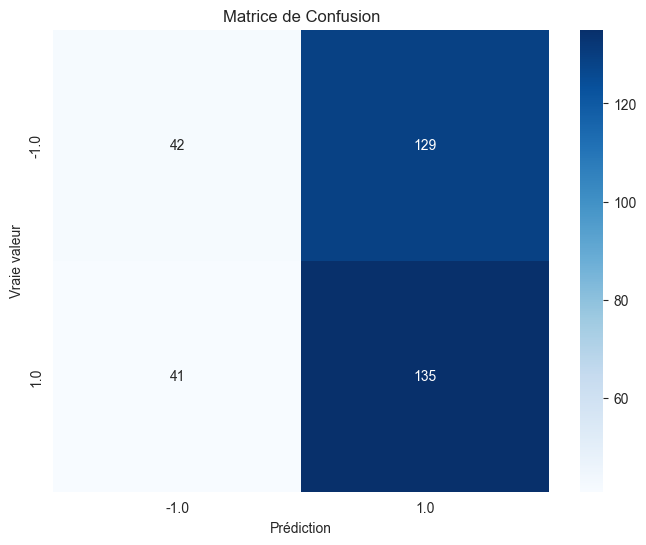

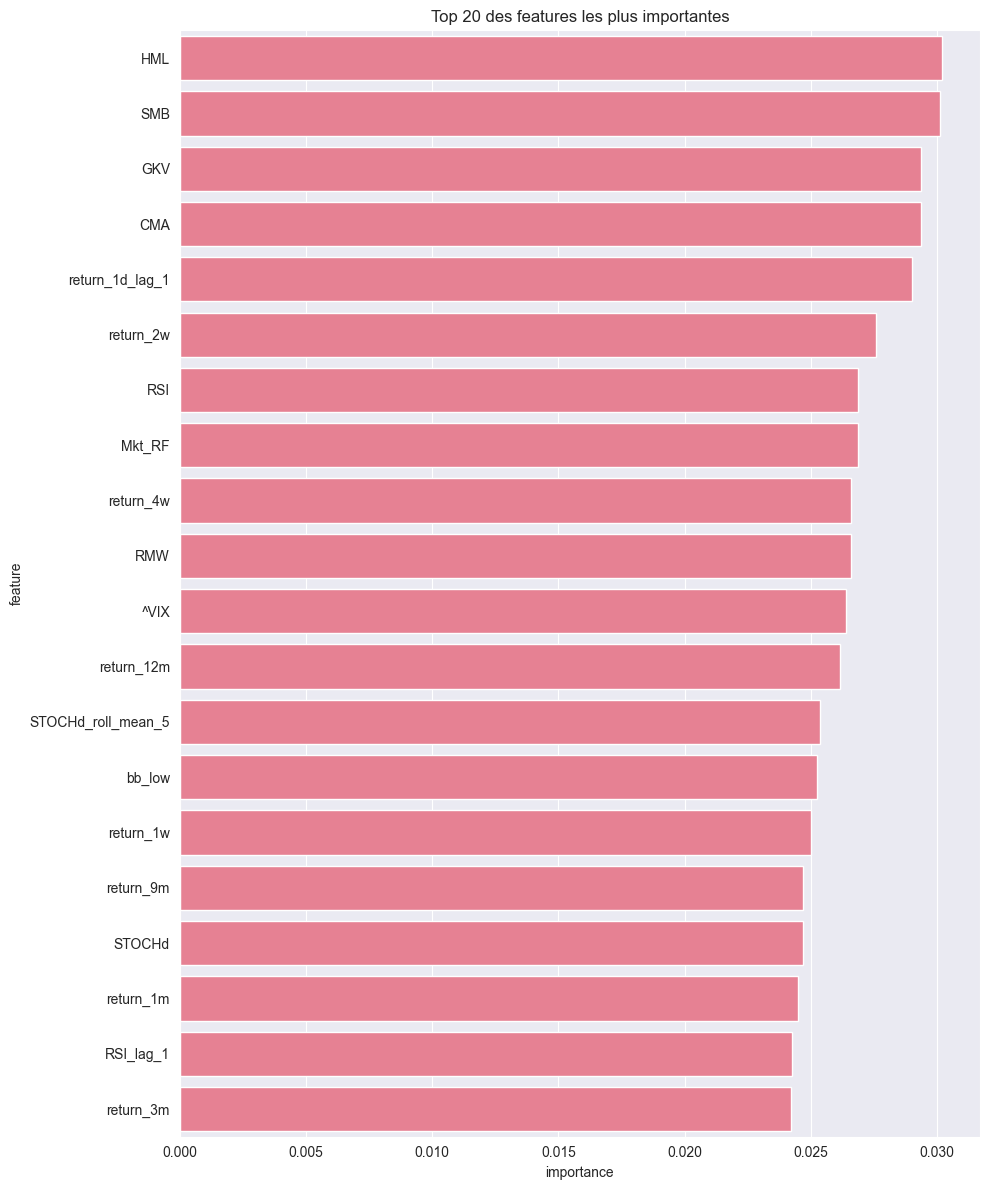

In [174]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- NOUVEAU : Simplification du problème en 2 classes ---
data_2class = data_featured[data_featured['target'] != 0].copy()

# --- 1. Préparation des données pour le modèle ---
y = data_2class['target']
X = data_2class.drop(columns=[
    'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Dollar Volume',
    'return_1d', 'log_return_1d', 'target'
], errors='ignore')

# Sécurité pour les NaN/inf
X.replace([np.inf, -np.inf], np.nan, inplace=True)
if X.isnull().sum().sum() > 0:
    X.dropna(inplace=True)
    y = y[X.index]

print(f"Forme des features (X) après filtrage : {X.shape}")
print(f"Forme de la cible (y) après filtrage : {y.shape}")

# --- 2. Division des données (Train / Test) ---
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"\nNombre d'échantillons d'entraînement : {len(X_train)}")
print(f"Nombre d'échantillons de test : {len(X_test)}")

# --- 3. Entraînement du modèle RandomForest ---
# class_weight='balanced' est utile si les classes sont déséquilibrées
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')

print("\nEntraînement du modèle...")
model.fit(X_train, y_train)
print("Entraînement terminé.")

# --- 4. Évaluation du modèle ---
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy sur l'ensemble de test : {accuracy:.2%}")

print("Rapport de classification :")
print(classification_report(y_test, y_pred, zero_division=0))

# --- 5. Analyse de l'importance des features ---
# (Le reste du code pour la matrice de confusion et l'importance des features est identique)
importances = model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# Afficher la matrice de confusion et les features importantes...
# (code des graphiques inchangé)
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Matrice de Confusion')
plt.xlabel('Prédiction')
plt.ylabel('Vraie valeur')
plt.show()

plt.figure(figsize=(10, 12))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20))
plt.title('Top 20 des features les plus importantes')
plt.tight_layout()
plt.show()

#Accuracy (51.01%) : On a dépassé la barre des 50%. Le modèle est maintenant légèrement meilleur qu'un tirage au sort aléatoire. C'est encore très faible, mais cela prouve qu'il commence à capter un signal, même s'il est très faible.
Rapport de Classification :
Classe 1.0 (Hausse) :
recall: 0.77 : Le rappel a un peu baissé (de 0.82 à 0.77), et c'est une bonne chose. Cela signifie que le modèle est moins obsédé par le fait de prédire "hausse" à tout prix. Il devient plus sélectif.
precision: 0.51 : La précision a légèrement augmenté (de 0.49 à 0.51).
Classe -1.0 (Baisse) :
recall: 0.25 : C'est la meilleure nouvelle ici. Le rappel a plus que doublé (passant de 0.12 à 0.25). Le modèle commence réellement à apprendre à identifier les jours de baisse. Il en trouve encore peu (seulement 1 sur 4), mais c'est bien mieux que 1 sur 10.
precision: 0.51 : Grosse amélioration de la précision (de 0.40 à 0.51). Quand il prédit une baisse, il a maintenant raison une fois sur deux.
Conclusion de l'interprétation : En simplifiant le problème (passant de 3 à 2 classes), nous avons forcé le modèle à arrêter sa stratégie simpliste. Il est maintenant plus équilibré et commence à trouver de vrais signaux pour prédire les baisses. La performance globale reste insuffisante pour une utilisation réelle.